# Fit rate curves

```md
From `./results/estimation/{test_name}.npz`
```

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
import sys
sys.path.append('../../src/')
sys.path.append('../../scripts/')
from solve_kolmogorov import *
from simulate_gillespie import *
from estimate_total_rates import *

from scipy.special import comb as nchoosek
from scipy.optimize import curve_fit

In [2]:
# setup
N = 1000
k_full_range = np.arange(N + 1)

# complete class true parameters for for actual rates a_k, b_k, lambda_k
true_beta1_for_complete = 2.4 / N
true_beta2_for_complete = 4.4 / (N**2)

test_names = ["complete", "random_ER", "regular", "scale_free"]
# TODO: choose colors for each class
class_colors = {
    "complete":   "red",
    "random_ER":  "green",
    "regular":    "blue",
    "scale_free": "darkorange"
}
# TODO: choose symbols for scatter points, tilde data
class_markers = { #
    "complete": "o",
    "random_ER": "s",
    "regular": "^",
    "scale_free": "D"
}
marker_size = 50
marker_alpha = 0.85

plot_labels = {
    "complete": "Complete", 
    "random_ER": "Erdős-Rényi", 
    "regular": "Regular",
    "scale_free": "Scale-Free"
}

In [3]:
test_names = ["complete", "random_ER", "regular", "scale_free"]
test_name = test_names[3]
test_name

'scale_free'

In [4]:
estimates = np.load(f'../../results/estimates/{test_name}.npz', allow_pickle=True)


 --- Class: complete --- 
Number of reliable data points for fitting: 757

a_k fit params (complete): C=2.40e-03, p=1.00, alpha=0.00
b_k fit params (complete): C=2.20e-06, p=1.00, alpha=0.00

 --- Class: random_ER --- 
Number of reliable data points for fitting: 742

a_k fit params (random_ER): C=1.82e-03, p=0.98, alpha=-0.07
b_k fit params (random_ER): C=3.82e-05, p=0.80, alpha=-0.23

 --- Class: regular --- 
Number of reliable data points for fitting: 772

a_k fit params (regular): C=1.54e-03, p=1.00, alpha=0.08
b_k fit params (regular): C=3.89e-05, p=0.80, alpha=0.13

 --- Class: scale_free --- 
Number of reliable data points for fitting: 732

a_k fit params (scale_free): C=3.13e-02, p=0.77, alpha=-0.61
b_k fit params (scale_free): C=1.09e-02, p=0.36, alpha=-1.03


/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/numpy/_core/numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


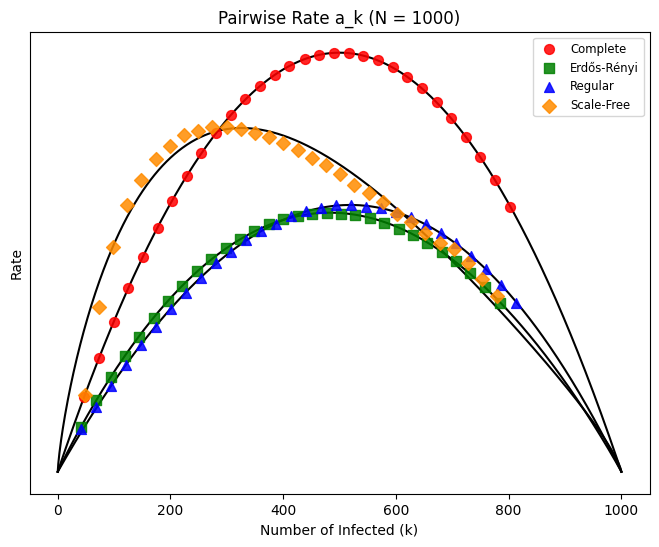

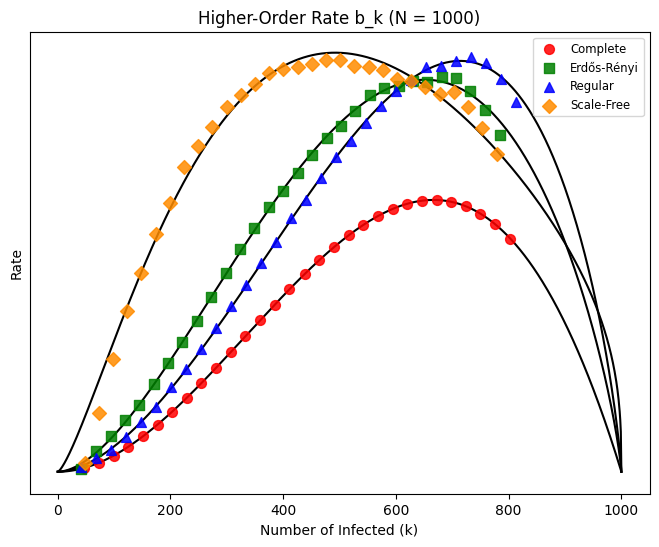

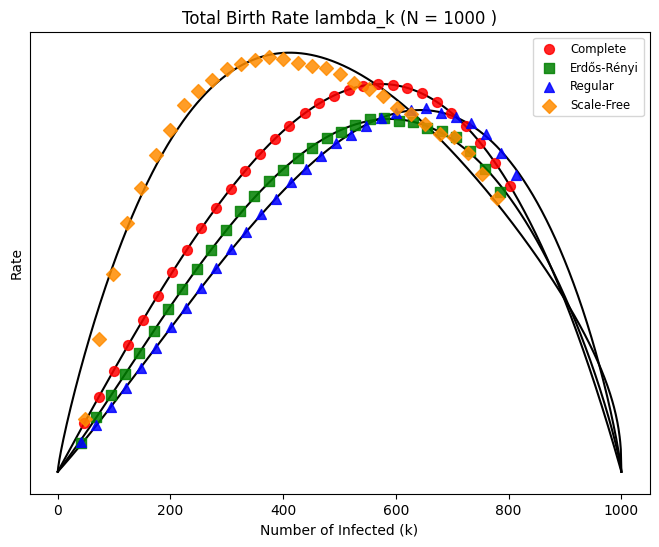

In [5]:
# --- 3 figures of combined plots for all 4 classes ---
fig_ak, ax_ak = plt.subplots(figsize=(8, 6))
fig_bk, ax_bk = plt.subplots(figsize=(8, 6))
fig_lk, ax_lk = plt.subplots(figsize=(8, 6))

for test_name in test_names:
    print(f"\n --- Class: {test_name} --- ")
    estimates = np.load(f'../../results/estimates/{test_name}.npz', allow_pickle=True)

    a_k_tilde_all = estimates["a_k_tilde"]
    b_k_tilde_all = estimates["b_k_tilde"]
    lambda_k_tilde_all = estimates["lambda_k_tilde"]
    T_k_all = estimates["T_k"]

    min_Tk_threshold = 0.1 # TODO: tune it
    valid_k_idx = T_k_all > min_Tk_threshold
    
    k_observed_reliable = k_full_range[valid_k_idx]
    ak_tilde_reliable = a_k_tilde_all[valid_k_idx]
    bk_tilde_reliable = b_k_tilde_all[valid_k_idx]
    lambda_k_tilde_reliable = lambda_k_tilde_all[valid_k_idx]

    print(f"Number of reliable data points for fitting: {len(k_observed_reliable)}")

    # default black color and dot marker
    default_color = "black"
    default_marker = "."

    current_color = class_colors.get(test_name, "black")
    current_marker = class_markers.get(test_name, ".")

    # --------------------
    # --- PW rates a_k ---
    # --------------------
    ak_peak_val = np.max(ak_tilde_reliable) if len(ak_tilde_reliable) > 0 else 0.01
    p_a_init = 1.5 if test_name == "scale_free" else 1.0
    alpha_a_init = -1.0 if test_name == "scale_free" else 0.0
    C_a_denom = ((N/2)**p_a_init * (N/2)**p_a_init) if N > 0 else 1
    C_a_init = ak_peak_val / C_a_denom if C_a_denom > 1e-9 else ak_peak_val
    p0_ak = [C_a_init, p_a_init, alpha_a_init]
    bounds_ak = ([0, 0.1, -5], [np.inf, 5, 2])

    ak_fitted = np.full_like(k_full_range, np.nan)
    popt_ak, _ = curve_fit(lambda k, C, p, alpha: di_lauro_ak_model(k, N, C, p, alpha),
                        k_observed_reliable, ak_tilde_reliable, p0=p0_ak, bounds=bounds_ak, maxfev=10000)
    ak_fitted = di_lauro_ak_model(k_full_range, N, *popt_ak)
    print(f"\na_k fit params ({test_name}): C={popt_ak[0]:.2e}, p={popt_ak[1]:.2f}, alpha={popt_ak[2]:.2f}")
    
    # --------------------
    # --- HO rates b_k ---
    # --------------------
    bk_peak_val = np.max(bk_tilde_reliable) if len(bk_tilde_reliable) > 0 else 1e-6
    
    # TODO: adjust for scale-free
    p_b_init = 1.0 if test_name == "scale_free" else 1.0
    alpha_b_init = 0.0 if test_name == "scale_free" else 0.0

    k_peak_b_approx = 2*N/3
    denom_cb = k_peak_b_approx * (k_peak_b_approx-1)**p_b_init * (N-k_peak_b_approx)**p_b_init if k_peak_b_approx > 1 and N-k_peak_b_approx > 0 else 1
    C_b_init = bk_peak_val / denom_cb if denom_cb > 1e-9 else bk_peak_val
    p0_bk = [C_b_init, p_b_init, alpha_b_init]
    bounds_bk = ([0, 0.1, -5], [np.inf, 5, 2])
    
    k_obs_for_bk_fit = k_observed_reliable[k_observed_reliable >= 2]
    bk_tilde_for_bk_fit = bk_tilde_reliable[k_observed_reliable >= 2]

    bk_fitted = np.full_like(k_full_range, np.nan)
    popt_bk, _ = curve_fit(lambda k, C, p, alpha: di_lauro_bk_model(k, N, C, p, alpha),
                            k_obs_for_bk_fit, bk_tilde_for_bk_fit, p0=p0_bk, bounds=bounds_bk, maxfev=10000)
    bk_fitted = di_lauro_bk_model(k_full_range, N, *popt_bk)
    print(f"b_k fit params ({test_name}): C={popt_bk[0]:.2e}, p={popt_bk[1]:.2f}, alpha={popt_bk[2]:.2f}")
    
    # ----------------------------
    # --- Total rates lambda_k ---
    # ----------------------------
    lambda_k_fitted = ak_fitted + bk_fitted

    # ----------------
    # --- Plotting ---
    # --- -------- ---
    # skipping labels for fits: label=f'{plot_labels[test_name]}'
    # TODO: sample from ak_tilde_reliable, bk_tilde_reliable, lambda_k_tilde_reliable
    num_scatter_points = 30 # TODO: 25 or 10, a number that looks good on the plot

    # Create equally spaced indices to select from the reliable data
    # This ensures we get points spanning the whole range of reliable data
    sample_indices = np.linspace(0, len(k_observed_reliable) - 1, num_scatter_points, dtype=int)

    k_scatter = k_observed_reliable[sample_indices]
    ak_tilde_scatter = ak_tilde_reliable[sample_indices]
    bk_tilde_scatter = bk_tilde_reliable[sample_indices]
    lambda_k_tilde_scatter = lambda_k_tilde_reliable[sample_indices]

    # a_k plot
    ax_ak.plot(k_full_range, ak_fitted, color=default_color, linewidth=1.5)
    ax_ak.scatter(k_scatter, ak_tilde_scatter, label=f'{plot_labels[test_name]}', 
                    alpha=marker_alpha, s=marker_size, color=current_color, marker=current_marker, zorder=10)

    # b_k plot
    ax_bk.plot(k_full_range, bk_fitted, color=default_color, linewidth=1.5)
    ax_bk.scatter(k_scatter, bk_tilde_scatter, label=f'{plot_labels[test_name]}', 
                    alpha=marker_alpha, s=marker_size, color=current_color, marker=current_marker, zorder=10)
    
    # lambda_k plot
    ax_lk.plot(k_full_range, lambda_k_fitted, color=default_color, linewidth=1.5)
    ax_lk.scatter(k_scatter, lambda_k_tilde_scatter, label=f'{plot_labels[test_name]}', 
                    alpha=marker_alpha, s=marker_size, color=current_color, marker=current_marker, zorder=10)
    

# --- ---------- ---
# --- Figure a_k ---
# --- ---------- ---
# if test_name == "complete":
#     # for complete we can add true theoretical curve
#     a_k_true_comp = true_beta1_for_complete * k_full_range * (N - k_full_range)
#     ax_ak.plot(k_full_range, a_k_true_comp, label='ak_true (Complete)', color='black', linestyle=':', linewidth=1.5, zorder=0)
ax_ak.set_xlabel("Number of Infected (k)")
ax_ak.set_ylabel("Rate")
ax_ak.set_title(f"Pairwise Rate a_k (N = {N})")
ax_ak.legend(fontsize='small')
# ax_ak.grid(True, linestyle=':') # TODO: no grid?
ax_ak.set_ylim(bottom=-0.05 * np.nanmax(ax_ak.get_ylim()[-1] if ax_ak.get_ylim()[-1]>0 else 1.0))
ax_ak.set_yticklabels([]) # TODO: decide y-axis tick labels (the numbers) should be there or not
ax_ak.set_yticks([])

# ------------------
# --- Figure b_k ---
# ------------------
# if test_name == "complete":
#     # for complete we can add true theoretical curve
#     binom_k_2 = np.zeros_like(k_full_range, dtype=float)
#     valid_binom_idx = k_full_range >= 2
#     binom_k_2[valid_binom_idx] = nchoosek(k_full_range[valid_binom_idx], 2, exact=False)
#     b_k_true_comp = true_beta2_for_complete * binom_k_2 * (N - k_full_range)
#     ax_bk.plot(k_full_range, b_k_true_comp, label='bk_true (Complete)', color='black', linestyle=':', linewidth=1.5, zorder=0)
ax_bk.set_xlabel("Number of Infected (k)")
ax_bk.set_ylabel("Rate")
ax_bk.set_title(f"Higher-Order Rate b_k (N = {N})")
ax_bk.legend(fontsize='small')
# ax_bk.grid(True, linestyle=':') # TODO: no grid?
ax_bk.set_ylim(bottom=-0.05 * np.nanmax(ax_bk.get_ylim()[-1] if ax_bk.get_ylim()[-1]>0 else 1.0))
ax_bk.set_yticklabels([]) # TODO: decide y-axis tick labels (the numbers) should be there or not
ax_bk.set_yticks([])

# -----------------------
# --- Figure lambda_k ---
# -----------------------
# if test_name == "complete":
#     # for complete we can add true theoretical curve
#     lambda_k_true_comp = a_k_true_comp + b_k_true_comp
#     ax_lk.plot(k_full_range, lambda_k_true_comp, label='lk_true (Complete)', color='black', linestyle=':', linewidth=1.5, zorder=0)
ax_lk.set_xlabel("Number of Infected (k)")
ax_lk.set_ylabel("Rate")
ax_lk.set_title(f"Total Birth Rate lambda_k (N = {N} )")
ax_lk.legend(fontsize='small')
# ax_lk.grid(True, linestyle=':') # TODO: no grid?
ax_lk.set_ylim(bottom=-0.05 * np.nanmax(ax_lk.get_ylim()[-1] if ax_lk.get_ylim()[-1]>0 else 1.0))
ax_lk.set_yticklabels([]) # TODO: decide y-axis tick labels (the numbers) should be there or not
ax_lk.set_yticks([])

plt.show()

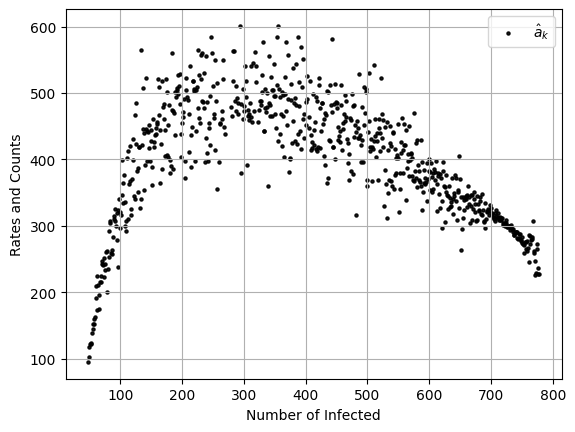

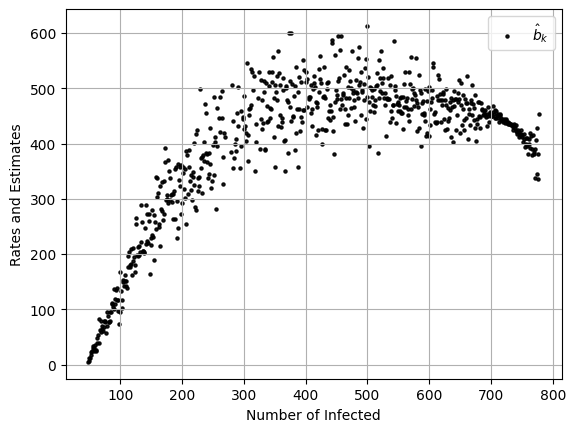

In [6]:
k_values = np.arange(N + 1)
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]

# plot only where T_k was non-zero!
min_Tk_threshold = 0.14 # TODO: tune the threshold
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

fig = plt.figure()
ax = plt.subplot()

ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx], s = 5,
        label=r'$\hat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True) 
plt.show()

fig = plt.figure()
ax = plt.subplot()
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx], s = 5,
        label=r'$\hat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.show()